In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [99]:
# These are your training samples along with their labels
data = pd.read_csv('health_insurance_train.csv')
data.head()
# You need to extract the features and the regression target. The regression target is 'whrswk'. 

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
0,40.0,no,yes,yes,13-15years,white,no,17.0,0.0,1.0,22.000,south
1,40.0,no,yes,yes,13-15years,white,no,4.0,1.0,0.0,15.000,south
2,0.0,yes,no,yes,16years,white,no,21.0,0.0,1.0,99.999,other
3,40.0,no,no,yes,13-15years,white,no,22.0,NaN,NaN,60.000,northcentral
4,35.0,no,yes,no,12years,white,no,15.0,0.0,2.0,0.000,south


In [133]:
X = data.drop('whrswk', axis=1)
y = data['whrswk']

In [ ]:
# # get only yes hhi from X
# print(X[(X['hhi']=='yes') & (X['hhi2']=='yes') & (X['whi']=='no')])

### Data Preprocessing

In [134]:
# Custom function to handle mapping for categorical columns
def map_columns(data):
    education_mapping = {
        '<9years': 8,
        '9-11years': 10,
        '12years': 12,
        '11-13years': 12,
        '13-15years': 14,
        '16years': 16,
        '>16years': 18
    }
    yn_mapping = {'yes': 1, 'no': 0}
    
    # Mapping categorical values
    if 'education' in data.columns:
        data['education'] = data['education'].map(education_mapping)
    if 'hhi' in data.columns:
        data['hhi'] = data['hhi'].map(yn_mapping)
    if 'whi' in data.columns:
        data['whi'] = data['whi'].map(yn_mapping)
    if 'hhi2' in data.columns:
        data['hhi2'] = data['hhi2'].map(yn_mapping)
    if 'hispanic' in data.columns:
        data['hispanic'] = data['hispanic'].map(yn_mapping)
    
    return data

In [135]:
# Define preprocessing pipelines
preprocessor_standard = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), ['experience', 'kidslt6', 'kids618', 'husby']),
    ('education', FunctionTransformer(map_columns), ['education']),
    ('yn_columns', FunctionTransformer(map_columns), ['hhi', 'whi', 'hhi2', 'hispanic']),
    ('onehot', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle NaN in categorical columns
        ('encoder', OneHotEncoder(drop='first'))
    ]), ['race', 'region'])
])


In [140]:
# Standard pipeline (scaling + preprocessing)
pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),
    ('scaler', StandardScaler())
])

# Pipeline with Polynomial Features
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_standard),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=45))
])

In [141]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
# Fit and transform the standard pipeline
X_1 = pipeline_1.fit_transform(X_train)
X_test_1 = pipeline_1.transform(X_test)

# Fit and transform the polynomial pipeline
X_2 = pipeline_2.fit_transform(X_train)
X_test_2 = pipeline_2.transform(X_test)

y_train = StandardScaler().fit_transform(y_train.values.reshape(-1, 1))
y_test = StandardScaler().fit_transform(y_test.values.reshape(-1, 1))

# print(f"PCA explained variance ratio: {np.sum(pipeline_2.named_steps['pca'].explained_variance_ratio_)}")
print(f"X_1 shape (standard pipeline): {X_1.shape}")
print(f"X_2 shape (polynomial pipeline): {X_2.shape}")


X_1 shape (standard pipeline): (4000, 14)
X_2 shape (polynomial pipeline): (4000, 119)


### Data Visualization

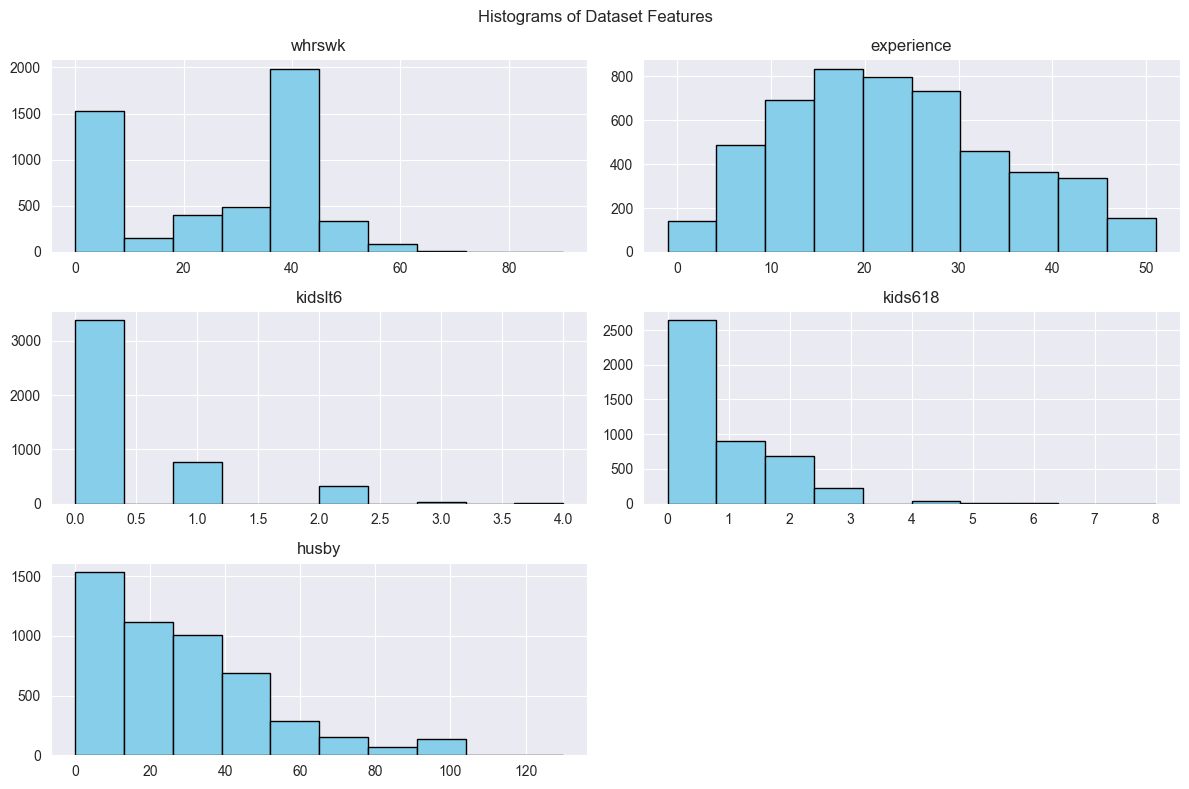

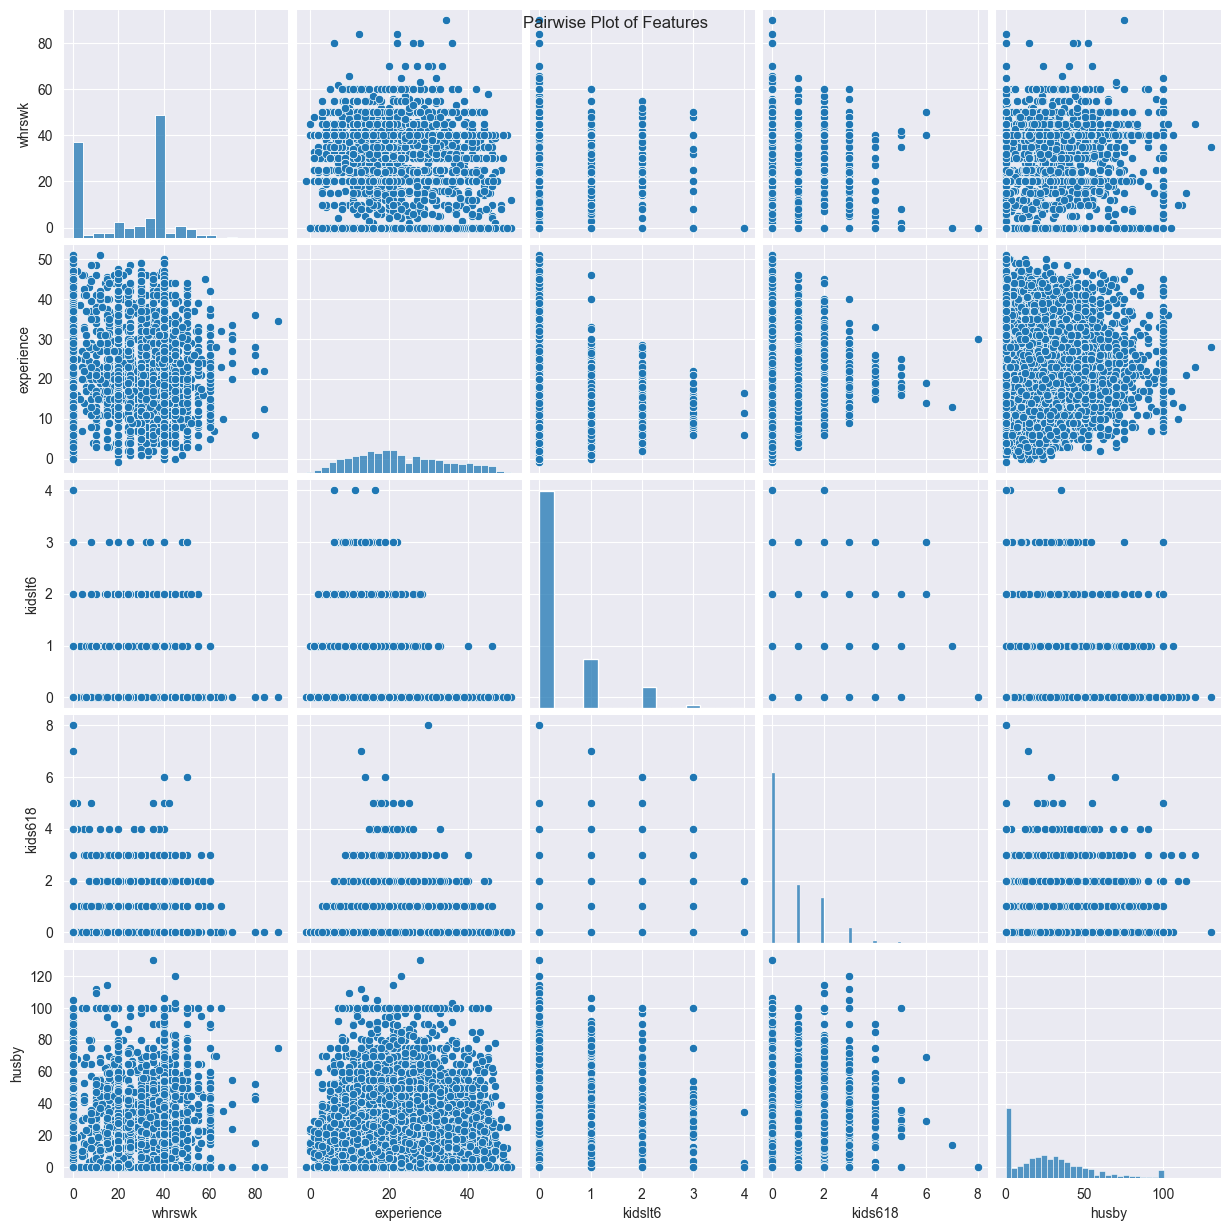

ValueError: could not convert string to float: 'no'

<Figure size 1000x600 with 0 Axes>

In [128]:
df = pd.concat([pd.DataFrame(X_1), pd.DataFrame(y_train)])

# 1. Histograms
data.hist(figsize=(12, 8), bins=10, color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Dataset Features')
plt.tight_layout()
plt.show()

# 2. Pairplot - Showing pairwise relationships
sns.pairplot(data)
plt.suptitle('Pairwise Plot of Features')
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
# 1. Scatter plot: hhi vs hhi2
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='hhi', y='hhi2')
plt.title('Scatter plot of hhi vs hhi2')
plt.show()

# 2. Scatter plot: whrswk vs whi
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='whrswk', y='whi')
plt.title('Scatter plot of whrswk vs whi')
plt.show()

# 3. Scatter plot: education vs whrswk
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='education', y='whrswk')
plt.title('Scatter plot of education vs whrswk')
plt.show()

# 4. Scatter plot: experience vs kidslt6
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='experience', y='kidslt6')
plt.title('Scatter plot of experience vs kidslt6')
plt.show()

### Training and Tuning all models

In [ ]:
def train(X_train, y_train, X_test, y_test):
    models = {
    'KNN': KNeighborsRegressor(),
    'Linear Regression (SGD)': SGDRegressor(eta0 = 0.001),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
    }
    
    default_model_mae = {}
    done_models = {}
    
    for name, model in models.items():
        if name!= 'Linear Regression (SGD)':
            print(f"Training {name} without tuning...")
        
            model.fit(X_train, y_train.ravel())
            
            y_pred = model.predict(X_test)
            
            mae = mean_absolute_error(y_test.ravel(), y_pred)
            default_model_mae[name] = mae
            print(f"{name} MAE: {mae}\n")
            
            done_models[name] = model
            
        else:
            
            mae_train_history = []
            mae_test_history = []
            n_epochs = 250
            for epoch in range(n_epochs):
                model.partial_fit(X_train, y_train.ravel())
                
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)
                
                mae_train = mean_absolute_error(y_train.ravel(), y_train_pred)
                mae_test = mean_absolute_error(y_test.ravel(), y_test_pred)
                
                mae_train_history.append(mae_train)
                mae_test_history.append(mae_test)
            
            final_mae_test = mae_test_history[-1]
            print(f"Final Test MAE: {final_mae_test}")
            
            # Plot the learning curve (MAE over epochs)
            plt.plot(range(n_epochs), mae_train_history, label='Train MAE')
            plt.plot(range(n_epochs), mae_test_history, label='Test MAE')
            plt.xlabel('Epochs')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.title('SGD Regressor Learning Curve')
            plt.legend()
            plt.show()
            

            done_models[name] = model
 
    return done_models
    

In [ ]:
models = train(X_1, y_train, X_test_1, y_test)

In [ ]:
models_2 = train(X_2, y_train, X_test_2, y_test)

### Tuning

In [ ]:
def tune(X_train, y_train, X_test, y_test, param_grids=None):
    if not param_grids:
        param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 10, 20, 100, 200, 500],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'Linear Regression (SGD)': {
        'eta0': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l2', 'l1']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, 40],
        'max_features': [None, 'sqrt', 'log2']
    }}

    models = {
        'KNN': KNeighborsRegressor(),
        'Linear Regression (SGD)': SGDRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Decision Tree': DecisionTreeRegressor(random_state=42)
    }
    
    # Store the best models
    best_models = {}
    
    # Loop through each model and perform GridSearchCV
    for name, model in models.items():
        print(f"Tuning hyperparameters for {name}...")
        param_grid = param_grids[name]
        
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train.ravel())
        
        # Get the best estimator
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        
        # Predict on the test set using the best model
        y_pred = best_model.predict(X_test)
        mae = mean_absolute_error(y_test.ravel(), y_pred)
        
        print(f"Best {name} MAE (after tuning): {mae}")
        print(f"Best Parameters for {name}: {grid_search.best_params_}\n")
    
    return best_models

In [126]:
best_1 = tune(X_1, y_train, X_test_1, y_test)

Tuning hyperparameters for KNN...
Best KNN MAE (after tuning): 0.639227191429854
Best Parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}

Tuning hyperparameters for Linear Regression (SGD)...
Best Linear Regression (SGD) MAE (after tuning): 0.6553025951500744
Best Parameters for Linear Regression (SGD): {'alpha': 0.0001, 'eta0': 0.01, 'penalty': 'l1'}

Tuning hyperparameters for Random Forest...
Best Random Forest MAE (after tuning): 0.6106657040614112
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}

Tuning hyperparameters for Decision Tree...
Best Decision Tree MAE (after tuning): 0.6242137324457326
Best Parameters for Decision Tree: {'max_depth': 5, 'max_features': None}


In [125]:
param_grids_1 = {
    'KNN': {
        'n_neighbors': [8, 9, 10, 11, 12],
        'weights': ['uniform'],
        'algorithm': ['auto']
    },
    'Linear Regression (SGD)': {
        'eta0': [0.01 ,0.02, 0.05, 0.08],
        'alpha': [0.0001, 0.0005],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [150, 200, 250],
        'max_depth': [5, 10, 15]
    },
    'Decision Tree': {
        'splitter': ['random'],
        'max_depth': [4, 5, 6, 8],
        'max_features': [None]
    }}

best_1_tuned = tune(X_1, y_train, X_test_1, y_test, param_grids_1)

Tuning hyperparameters for KNN...
Best KNN MAE (after tuning): 0.6347338861844556
Best Parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'uniform'}

Tuning hyperparameters for Linear Regression (SGD)...
Best Linear Regression (SGD) MAE (after tuning): 0.6535514791035887
Best Parameters for Linear Regression (SGD): {'alpha': 0.0001, 'eta0': 0.01, 'penalty': 'l2'}

Tuning hyperparameters for Random Forest...
Best Random Forest MAE (after tuning): 0.6101568707031065
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 150}

Tuning hyperparameters for Decision Tree...
Best Decision Tree MAE (after tuning): 0.6242137324457327
Best Parameters for Decision Tree: {'max_depth': 5, 'max_features': None}


In [123]:
param_grids_untuned_2 = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 10, 20, 100, 200, 500],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'Linear Regression (SGD)': {
        'eta0': [0.001, 0.01, 0.1, 1.0],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l2', 'l1']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, 40],
        'max_features': [None, 'sqrt', 'log2']
    }}
best_2 = tune(X_2, y_train, X_test_2, y_test, param_grids_2)

Tuning hyperparameters for KNN...
Best KNN MAE (after tuning): 0.6359639430489299
Best Parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}

Tuning hyperparameters for Linear Regression (SGD)...
Best Linear Regression (SGD) MAE (after tuning): 0.6461352292843612
Best Parameters for Linear Regression (SGD): {'alpha': 0.01, 'eta0': 0.001, 'penalty': 'l2'}

Tuning hyperparameters for Random Forest...
Best Random Forest MAE (after tuning): 0.6226653696196752
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}

Tuning hyperparameters for Decision Tree...
Best Decision Tree MAE (after tuning): 0.6345778934177941
Best Parameters for Decision Tree: {'max_depth': 5, 'max_features': None}


In [124]:
param_grids_2_tuned = {
    'KNN': {
        'n_neighbors': [8, 10, 12, 14],
        'weights': ['uniform'],
        'algorithm': ['auto']
    },
    'Linear Regression (SGD)': {
        'eta0': [0.001, 0.002, 0.004, 0.006, 0.008],
        'alpha': [0.01, 0.02, 0.04, 0.06, 0.08],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [150, 200, 250],
        'max_depth': [10]
    },
    'Decision Tree': {
        'max_depth': [4, 5, 6, 8],
        'max_features': [None]
    }}

best_2_tuned = tune(X_2, y_train, X_test_2, y_test, param_grids_2_tuned)

Tuning hyperparameters for KNN...
Best KNN MAE (after tuning): 0.6359639430489299
Best Parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}

Tuning hyperparameters for Linear Regression (SGD)...
Best Linear Regression (SGD) MAE (after tuning): 0.652795056497753
Best Parameters for Linear Regression (SGD): {'alpha': 0.02, 'eta0': 0.002, 'penalty': 'l2'}

Tuning hyperparameters for Random Forest...
Best Random Forest MAE (after tuning): 0.6222577094370053
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 250}

Tuning hyperparameters for Decision Tree...
Best Decision Tree MAE (after tuning): 0.640935175924468
Best Parameters for Decision Tree: {'max_depth': 6, 'max_features': None}


### Testing